In [1]:
# Feature Engineering - Lin Polar Images
import cv2
import matplotlib.pyplot as plt
import numpy as np

print('OpenCV version: {}'.format(cv2.__version__))

OpenCV version: 3.4.4


In [2]:
# Read in two different whales
im1 = cv2.cvtColor(
    cv2.imread(r'/home/share/dataset/kaggle_whale/train/0000e88ab.jpg', cv2.IMREAD_UNCHANGED),
    cv2.COLOR_BGR2RGB
)
im1_notch = np.array([543, 308])
im2 = cv2.cvtColor(
    cv2.imread(r'/home/share/dataset/kaggle_whale/train/0001f9222.jpg', cv2.IMREAD_UNCHANGED),
    cv2.COLOR_BGR2RGB
)
im2_notch = np.array([355, 167])
im3 = cv2.cvtColor(
    cv2.imread(r'/home/share/dataset/kaggle_whale/train/00029d126.jpg', cv2.IMREAD_UNCHANGED),
    cv2.COLOR_BGR2RGB
)
im3_notch = np.array([507, 253])
im4 = cv2.cvtColor(
    cv2.imread(r'/home/share/dataset/kaggle_whale/train/000a6daec.jpg', cv2.IMREAD_UNCHANGED),
    cv2.COLOR_BGR2RGB
)
im4_notch = np.array([576, 180])

def pol2cart2D(pol_coord, center):
    x = pol_coord[:, 0] * np.cos(pol_coord[:, 1]) + center[0]
    y = pol_coord[:, 0] * np.sin(pol_coord[:, 1]) + center[1]
    return np.vstack((x, y)).T

def get_quad(image, base_coordinates):
    base_coordinates[0] = max(min(base_coordinates[0], image.shape[1]-1), 0)
    base_coordinates[1] = max(min(base_coordinates[1], image.shape[0]-1), 0)
    try:
        ul = image[base_coordinates[1], base_coordinates[0]]
    except IndexError:
        ul = np.zeros_like(image[0,0,:])
    try:
        ur = image[base_coordinates[1], base_coordinates[0]+1]
    except IndexError:
        ur = ul
    try:
        ll = image[base_coordinates[1]+1, base_coordinates[0]]
    except IndexError:
        ll = ul
    try:
        lr = image[base_coordinates[1]+1, base_coordinates[0]+1]
    except IndexError:
        lr = ul
    return ul, ur, ll, lr


def interpolate2D(image, coordinates):
    assert len(coordinates) >= 2
    coordinates_whole = coordinates.astype(np.uint)
    coordinates_frac = coordinates - coordinates_whole
    ul, ur, ll, lr = get_quad(image, coordinates_whole)
    color = (1-coordinates_frac[0])*(1-coordinates_frac[1])*ul.astype(np.float) + \
            (coordinates_frac[0])*(1-coordinates_frac[1])*ur.astype(np.float) + \
            (1-coordinates_frac[0])*(coordinates_frac[1])*ll.astype(np.float) + \
            (coordinates_frac[0])*(coordinates_frac[1])*lr.astype(np.float)
    return (color + 0.5).astype(np.uint)


# Convert images to polar images at centerpoint
def cart_to_polar_image(cart_image, center):
    try:
        channels = cart_image.shape[2]
    except:
        channels = 1
    # Inverse transform polar mesh grid into cartesian coordinates
    image_R = np.sqrt((cart_image.shape[0] / 2) ** 2 + (cart_image.shape[1] / 2) ** 2)
    # Step radius by 1px in the longest dimension
    image_dr = 1  # aligned to pixel pitch, so our sampling is undistorted along a cartesian axis
    image_r = np.arange(image_R / image_dr)
    # Try not to change the total number of pixels in the image
    image_nphi = cart_image.shape[0] * cart_image.shape[1] / image_r.shape[0]
    image_dphi = 2 * np.pi / image_nphi
    image_phi = np.arange(0, 2 * np.pi, image_dphi)
    pol_image_shape = (image_r.shape[0], image_phi.shape[0], channels)
    pol_image = np.empty(pol_image_shape)
    pol_image = pol_image.astype(cart_image.dtype)

    image_r_mesh, image_theta_mesh = np.meshgrid(image_r, image_phi)
    image_r_phi = np.dstack((image_r_mesh, image_theta_mesh))
    image_r_phi_in_cart = np.reshape(
        pol2cart2D(np.reshape(image_r_phi, (np.multiply(*image_r_phi.shape[0:2]), image_r_phi.shape[2])), center),
        image_r_phi.shape
    )
    image_r_phi_serial = np.reshape(image_r_phi, (np.multiply(*image_r_phi.shape[0:2]), image_r_phi.shape[2])) / np.array((image_dr, image_dphi))
    image_r_phi_in_cart_serial = np.reshape(image_r_phi_in_cart, (np.multiply(*image_r_phi_in_cart.shape[0:2]), image_r_phi_in_cart.shape[2]))
    # Bilinearly interpolate image into polar image
    for polar, cart in zip(image_r_phi_serial, image_r_phi_in_cart_serial):
        # Bilinearly interpolate the cartesian image
        pol_image[int(polar[0]+0.5), int(polar[1]+0.5), :] = interpolate2D(cart_image, cart)

    return pol_image


im1_polar = cart_to_polar_image(im1, im1_notch)
im2_polar = cart_to_polar_image(im2, im2_notch)
im3_polar = cart_to_polar_image(im3, im3_notch)
im4_polar = cart_to_polar_image(im4, im4_notch)


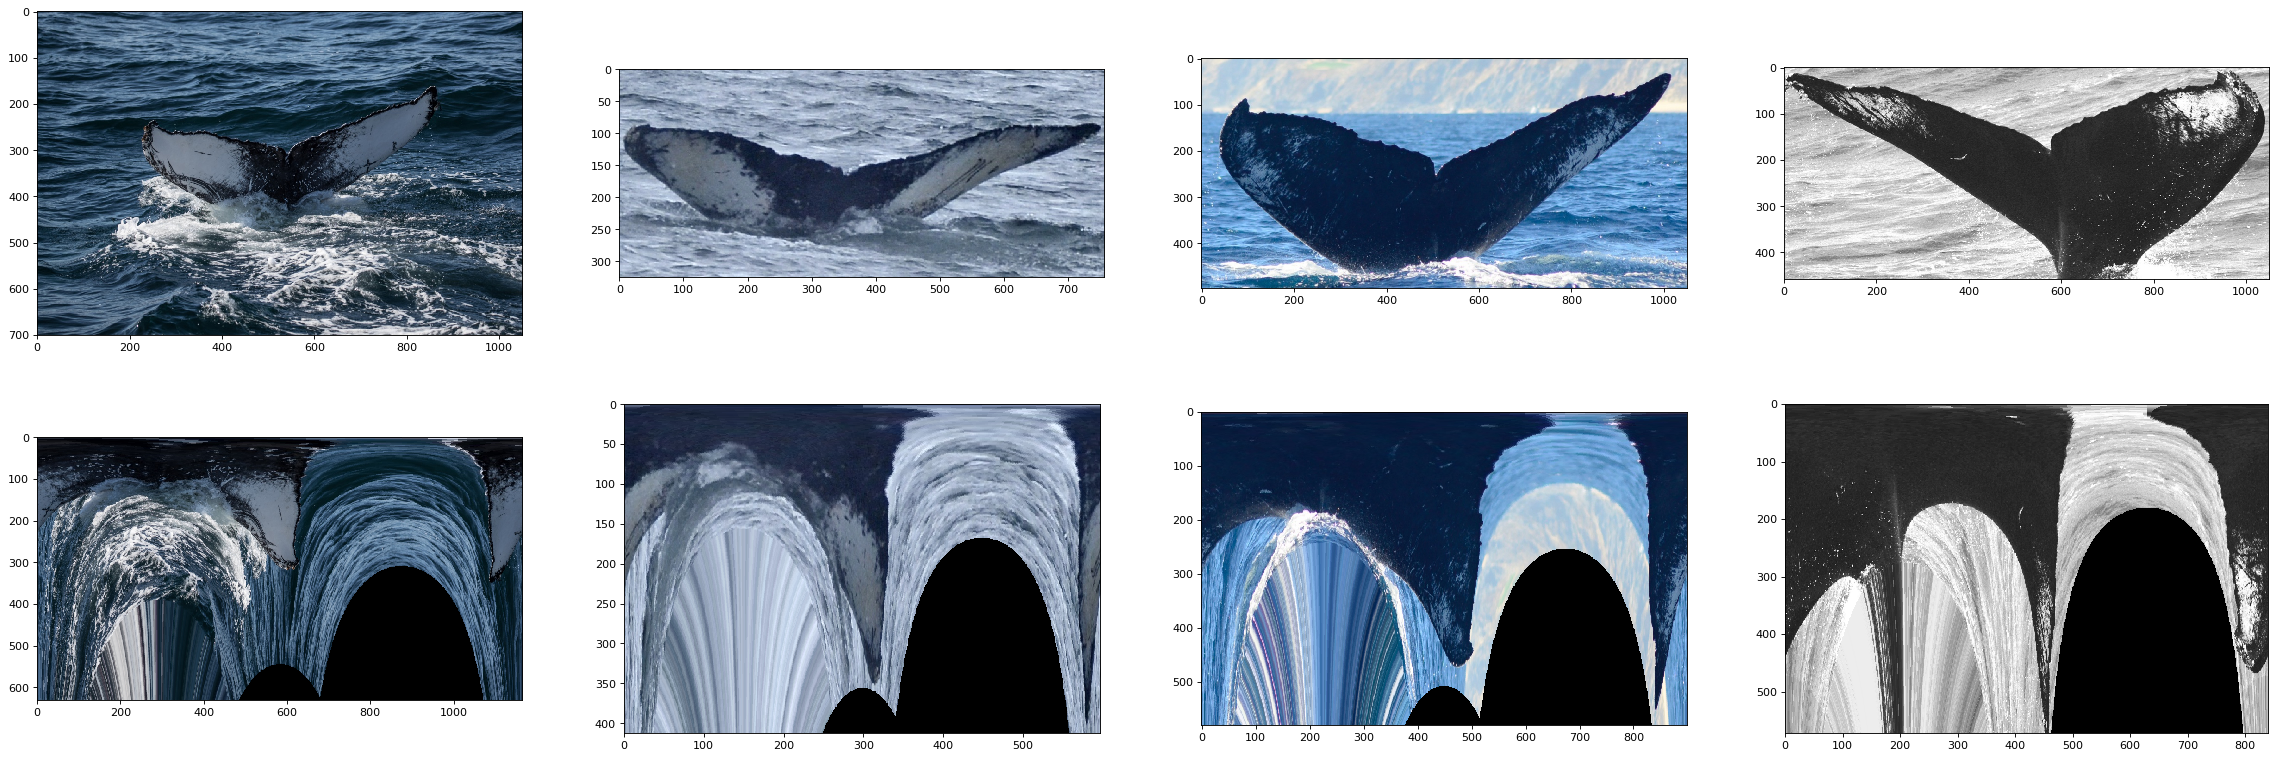

In [3]:
f = plt.figure(
    num=1,
    figsize=(36,12),
    dpi=80,
    facecolor='w',
    edgecolor='k'
)
plt.subplot(2,4,1)
f.gca().grid(False)
plt.imshow(im1)
plt.subplot(2,4,2)
f.gca().grid(False)
plt.imshow(im2)
plt.subplot(2,4,3)
f.gca().grid(False)
plt.imshow(im3)
plt.subplot(2,4,4)
f.gca().grid(False)
plt.imshow(im4)
plt.subplot(2,4,5)
f.gca().grid(False)
plt.imshow(im1_polar)
plt.subplot(2,4,6)
f.gca().grid(False)
plt.imshow(im2_polar)
plt.subplot(2,4,7)
f.gca().grid(False)
plt.imshow(im3_polar)
plt.subplot(2,4,8)
f.gca().grid(False)
plt.imshow(im4_polar)
plt.show()


In [27]:
# Train network on MiniVGGNet
from start.model import MiniVGGNet
from tensorflow.keras.backend import clear_session
clear_session()

WIDTH = 384
HEIGHT = 384

model = MiniVGGNet.build({
    'width': WIDTH,
    'height': HEIGHT,
    'channels': 3,
    'classes': 4
})

from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(
    lr=0.01, 
    rho=0.8, 
    epsilon=None, 
    decay=0.0
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

from sklearn.preprocessing import LabelBinarizer

labels_encoded = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
from start.preprocessing import ResizePreprocessor, ImageToTensorPreprocessor
resizer = ResizePreprocessor(
    width=WIDTH,
    height=HEIGHT,
    aspect_preserving=True
)
tensor = ImageToTensorPreprocessor()
im1_resize = tensor.preprocess(resizer.preprocess(im1))
im2_resize = tensor.preprocess(resizer.preprocess(im2))
im3_resize = tensor.preprocess(resizer.preprocess(im3))
im4_resize = tensor.preprocess(resizer.preprocess(im4))
data = np.stack((im1_resize, im2_resize, im3_resize, im4_resize))

history = model.fit(
    x=data,
    y=labels_encoded, 
    batch_size=None, 
    epochs=25,
    verbose=1,
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True, 
    class_weight=None, 
    sample_weight=None, 
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None
)

#del model
#import gc
#gc.collect()

Epoch 1/25


4/4 [==============================] - 1s 324ms/step - loss: 4.0351 - acc: 0.0000e+00


Epoch 2/25
4/4 [==============================] - 0s 30ms/step - loss: 3.4190 - acc: 0.2500


Epoch 3/25


4/4 [==============================] - 0s 30ms/step - loss: 0.0077 - acc: 1.0000


Epoch 4/25


4/4 [==============================] - 0s 31ms/step - loss: 3.9083e-04 - acc: 1.0000


Epoch 5/25


4/4 [==============================] - 0s 30ms/step - loss: 6.7442e-04 - acc: 1.0000


Epoch 6/25


4/4 [==============================] - 0s 31ms/step - loss: 3.6735e-04 - acc: 1.0000


Epoch 7/25


4/4 [==============================] - 0s 31ms/step - loss: 1.3779e-04 - acc: 1.0000


Epoch 8/25


4/4 [==============================] - 0s 30ms/step - loss: 6.6313e-05 - acc: 1.0000


Epoch 9/25


4/4 [==============================] - 0s 31ms/step - loss: 8.4003e-05 - acc: 1.0000


Epoch 10/25


4/4 [==============================] - 0s 31ms/step - loss: 1.0945e-04 - acc: 1.0000


Epoch 11/25


4/4 [==============================] - 0s 31ms/step - loss: 2.0780e-04 - acc: 1.0000


Epoch 12/25


4/4 [==============================] - 0s 31ms/step - loss: 4.7357e-05 - acc: 1.0000


Epoch 13/25


4/4 [==============================] - 0s 31ms/step - loss: 3.5079e-05 - acc: 1.0000


Epoch 14/25


4/4 [==============================] - 0s 31ms/step - loss: 1.0535e-04 - acc: 1.0000


Epoch 15/25


4/4 [==============================] - 0s 33ms/step - loss: 8.0487e-05 - acc: 1.0000


Epoch 16/25


4/4 [==============================] - 0s 32ms/step - loss: 6.5170e-05 - acc: 1.0000


Epoch 17/25


4/4 [==============================] - 0s 32ms/step - loss: 4.4437e-05 - acc: 1.0000


Epoch 18/25


4/4 [==============================] - 0s 34ms/step - loss: 7.1919e-05 - acc: 1.0000


Epoch 19/25


4/4 [==============================] - 0s 32ms/step - loss: 4.2306e-05 - acc: 1.0000


Epoch 20/25


4/4 [==============================] - 0s 32ms/step - loss: 1.3098e-05 - acc: 1.0000


Epoch 21/25


4/4 [==============================] - 0s 32ms/step - loss: 6.9284e-05 - acc: 1.0000


Epoch 22/25


4/4 [==============================] - 0s 32ms/step - loss: 2.4260e-05 - acc: 1.0000


Epoch 23/25


4/4 [==============================] - 0s 31ms/step - loss: 5.3856e-05 - acc: 1.0000


Epoch 24/25


4/4 [==============================] - 0s 33ms/step - loss: 6.1862e-05 - acc: 1.0000


Epoch 25/25


4/4 [==============================] - 0s 32ms/step - loss: 1.7554e-05 - acc: 1.0000


In [28]:
# Train network on MiniVGGNet
from start.model import MiniVGGNet
from tensorflow.keras.backend import clear_session
#clear_session()

WIDTH_POLAR = 384
HEIGHT_POLAR = 384

model_polar = MiniVGGNet.build({
    'width': WIDTH_POLAR,
    'height': HEIGHT_POLAR,
    'channels': 3,
    'classes': 4
})

from tensorflow.keras.optimizers import RMSprop
opt_polar = RMSprop(
    lr=0.01, 
    rho=0.8, 
    epsilon=None, 
    decay=0.0
)

model_polar.compile(
    loss='categorical_crossentropy',
    optimizer=opt_polar,
    metrics=['accuracy']
)

from sklearn.preprocessing import LabelBinarizer

labels_polar_encoded = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
from start.preprocessing import ResizePreprocessor, ImageToTensorPreprocessor
resizer_polar = ResizePreprocessor(
    width=WIDTH_POLAR,
    height=HEIGHT_POLAR,
    aspect_preserving=True
)
tensor_polar = ImageToTensorPreprocessor()
im1_polar_resize = tensor_polar.preprocess(resizer_polar.preprocess(im1_polar))
im2_polar_resize = tensor_polar.preprocess(resizer_polar.preprocess(im2_polar))
im3_polar_resize = tensor_polar.preprocess(resizer_polar.preprocess(im3_polar))
im4_polar_resize = tensor_polar.preprocess(resizer_polar.preprocess(im4_polar))
data_polar = np.stack((im1_polar_resize, im2_polar_resize, im3_polar_resize, im4_polar_resize))

history_polar = model_polar.fit(
    x=data_polar,
    y=labels_polar_encoded, 
    batch_size=None, 
    epochs=25,
    verbose=1,
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True, 
    class_weight=None, 
    sample_weight=None, 
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None
)

#del model_polar
#import gc
#gc.collect()

Epoch 1/25


4/4 [==============================] - 1s 345ms/step - loss: 2.6899 - acc: 0.0000e+00


Epoch 2/25
4/4 [==============================] - 0s 30ms/step - loss: 0.6535 - acc: 0.7500


Epoch 3/25


4/4 [==============================] - 0s 31ms/step - loss: 8.6578e-04 - acc: 1.0000


Epoch 4/25


4/4 [==============================] - 0s 31ms/step - loss: 8.4530e-05 - acc: 1.0000


Epoch 5/25


4/4 [==============================] - 0s 31ms/step - loss: 6.1040e-05 - acc: 1.0000


Epoch 6/25


4/4 [==============================] - 0s 31ms/step - loss: 5.1946e-04 - acc: 1.0000


Epoch 7/25


4/4 [==============================] - 0s 31ms/step - loss: 2.5750e-05 - acc: 1.0000


Epoch 8/25


4/4 [==============================] - 0s 31ms/step - loss: 9.0232e-05 - acc: 1.0000


Epoch 9/25


4/4 [==============================] - 0s 31ms/step - loss: 3.0027e-05 - acc: 1.0000


Epoch 10/25


4/4 [==============================] - 0s 31ms/step - loss: 1.4171e-05 - acc: 1.0000


Epoch 11/25


4/4 [==============================] - 0s 31ms/step - loss: 2.1414e-05 - acc: 1.0000


Epoch 12/25


4/4 [==============================] - 0s 31ms/step - loss: 1.0540e-04 - acc: 1.0000


Epoch 13/25


4/4 [==============================] - 0s 32ms/step - loss: 6.0563e-05 - acc: 1.0000


Epoch 14/25


4/4 [==============================] - 0s 32ms/step - loss: 1.3694e-05 - acc: 1.0000


Epoch 15/25


4/4 [==============================] - 0s 31ms/step - loss: 4.5049e-05 - acc: 1.0000


Epoch 16/25


4/4 [==============================] - 0s 33ms/step - loss: 1.9953e-05 - acc: 1.0000


Epoch 17/25


4/4 [==============================] - 0s 32ms/step - loss: 8.1510e-06 - acc: 1.0000


Epoch 18/25


4/4 [==============================] - 0s 32ms/step - loss: 8.1957e-06 - acc: 1.0000


Epoch 19/25


4/4 [==============================] - 0s 32ms/step - loss: 1.0506e-05 - acc: 1.0000


Epoch 20/25


4/4 [==============================] - 0s 32ms/step - loss: 3.3798e-05 - acc: 1.0000


Epoch 21/25


4/4 [==============================] - 0s 32ms/step - loss: 4.4826e-05 - acc: 1.0000


Epoch 22/25


4/4 [==============================] - 0s 32ms/step - loss: 2.5332e-06 - acc: 1.0000


Epoch 23/25


4/4 [==============================] - 0s 32ms/step - loss: 3.1190e-05 - acc: 1.0000


Epoch 24/25


4/4 [==============================] - 0s 32ms/step - loss: 3.9637e-06 - acc: 1.0000


Epoch 25/25


4/4 [==============================] - 0s 32ms/step - loss: 2.3083e-05 - acc: 1.0000


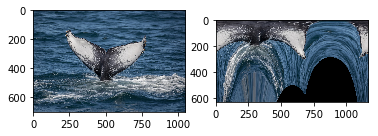

In [23]:
# Test whale 0af805558.jpg
test_whale = cv2.cvtColor(
    cv2.imread(r'/home/share/dataset/kaggle_whale/train/0af805558.jpg', cv2.IMREAD_UNCHANGED),
    cv2.COLOR_BGR2RGB
)
test_whale_notch = np.array([502, 288])
test_whale_polar = cart_to_polar_image(test_whale, test_whale_notch)

f = plt.figure()
plt.subplot(1,2,1)
plt.imshow(test_whale)
plt.subplot(1,2,2)
plt.imshow(test_whale_polar)

In [31]:
test_whale_resize = tensor.preprocess(resizer.preprocess(test_whale))
test_whale_resize = test_whale_resize[np.newaxis,:,:,:]

print(model.predict(test_whale_resize))
# It should be first_whale

[[0. 1. 0. 0.]]


In [32]:
test_whale_polar_resize = tensor.preprocess(resizer.preprocess(test_whale_polar))
test_whale_polar_resize = test_whale_polar_resize[np.newaxis,:,:,:]

print(model_polar.predict(test_whale_polar_resize))
# It should be first_whale

[[0.000000e+00 0.000000e+00 1.000000e+00 6.336506e-25]]


In [26]:
del model
del model_polar
import gc
gc.collect()

237522